This notebook focuses on analysing the startups, specifically the industries and extracting some insights from them. This covers industry-level insights, funding patterns, and text-driven topic discovery using NLP clustering.

The goal of this section is to answer:

**“What industries dominate the European startup landscape, how are they funded, and what patterns emerge when we analyze company descriptions at scale?”**

Lets start with importing all the necessary libraries and frameworks. If anything is needed further down, I will just put it back up while cleaning the notebook.

In [1]:
import psycopg2
from dotenv import load_dotenv
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer

load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("host"),
    port=os.getenv("port"),
    dbname=os.getenv("dbname"),
    user=os.getenv("user"),
    password=os.getenv("password"),
)


/workspaces/dsi-ws2025-project-grpab-weigl-mds1ab-awp-proj2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
query = """
SELECT
    c.id                AS company_id,
    c.company_name,
    c.funding_amount,
    c.start_year,
    c.website,
    ci.city_name,
    co.country_code,
    co.country,
    s.is_active,
    s.status,
    ARRAY_AGG(DISTINCT it.industry_tag ORDER BY it.industry_tag) AS industries
FROM company c
LEFT JOIN city ci
    ON c.city_id = ci.city_id
LEFT JOIN country co
    ON ci.country_code = co.country_code
LEFT JOIN status s
    ON c.status_id = s.status_id
LEFT JOIN company_industries ci_map
    ON c.id = ci_map.company_id
LEFT JOIN industry_tags it
    ON ci_map.industry_id = it.industry_id
GROUP BY
    c.id,
    c.company_name,
    c.funding_amount,
    c.start_year,
    c.website,
    ci.city_name,
    co.country_code,
    co.country,
    s.is_active,
    s.status
ORDER BY c.id;
"""

df_industry_base = pd.read_sql(query, conn)

# Converting PostgreSQL arrays into Python lists (just in case)
if "industries" in df_industry_base.columns:
    df_industry_base["industries"] = df_industry_base["industries"].apply(
        lambda x: [i for i in x if i is not None] if isinstance(x, (list, tuple)) else []
    )

df_industry_base.head()

/tmp/ipykernel_44232/2458464218.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_industry_base = pd.read_sql(query, conn)


,company_id,company_name,funding_amount,start_year,website,city_name,country_code,country,is_active,status,industries
0,3706,Tagbase,300000.0,2025.0,https://tagbase.io,Vienna,AUT,Austria,True,active,"[Analytics, Product Authenticity, Software Dev..."
1,3707,Proofcheck,300000.0,2022.0,https://www.proofcheck.io/,Vienna,AUT,Austria,True,active,"[AI, Multilingual Machine, PDFs, Web app]"
2,3708,Repose,NaN,2017.0,www.reposee.com,Vienna,AUT,Austria,True,active,"[Rental platform, Travel Tech]"
3,3709,Salzburger Eisenbahn Transportlogistik,NaN,2001.0,setg.at,Salzburg,AUT,Austria,None,None,[Rail Freight Transport]
4,3710,Streamtv Media,1750000.0,2018.0,https://www.stream.tv/,Steyr,AUT,Austria,True,active,"[Online Games, Video, Video Streaming]"


The SQL query above joins these tables and produces a single, consolidated view.

For each company, we extract:
1. basic company details (company_name, start_year, funding_amount, website)
2. location (city_name, country_code, country)
3. operational status (is_active, status)
4. associated industry tags, aggregated into a list

Finally, a small post-processing step converts PostgreSQL array fields into standard Python lists to ensure compatibility with downstream Pandas and NLP operations.

In [3]:
print("Shape:", df_industry_base.shape)
print("\nColumns:", df_industry_base.columns.tolist())

print("\nNull counts:")
print(df_industry_base.isna().sum())

print("\nSample rows (just to eyeball industries & geography):")
df_industry_base[["company_id", "company_name", "country", "city_name", "industries", "funding_amount", "start_year"]].head(10)


Shape: (37534, 11)

Columns: ['company_id', 'company_name', 'funding_amount', 'start_year', 'website', 'city_name', 'country_code', 'country', 'is_active', 'status', 'industries']

Null counts:
company_id            0
company_name          0
funding_amount    24449
start_year          349
website               0
city_name           346
country_code        346
country             346
is_active          7478
status             7478
industries            0
dtype: int64

Sample rows (just to eyeball industries & geography):


,company_id,company_name,country,city_name,industries,funding_amount,start_year
0,3706,Tagbase,Austria,Vienna,"[Analytics, Product Authenticity, Software Dev...",300000.0,2025.0
1,3707,Proofcheck,Austria,Vienna,"[AI, Multilingual Machine, PDFs, Web app]",300000.0,2022.0
2,3708,Repose,Austria,Vienna,"[Rental platform, Travel Tech]",NaN,2017.0
3,3709,Salzburger Eisenbahn Transportlogistik,Austria,Salzburg,[Rail Freight Transport],NaN,2001.0
4,3710,Streamtv Media,Austria,Steyr,"[Online Games, Video, Video Streaming]",1750000.0,2018.0
5,3711,Caterme,Austria,Piringsdorf,"[catering, events]",NaN,2020.0
6,3712,Happy Plates,Austria,Vienna,"[Content Creators, Cooking, E-Commerce, Food D...",1750000.0,2018.0
7,3713,Vitrealab,Austria,Vienna,"[Deeptech, Engineering, Manufacturing]",1750000.0,2018.0
8,3714,Streemfire,Austria,Vienna,"[Internet, Media and Enterainment, Video Strea...",NaN,2020.0
9,3715,Sortask,Austria,Graz,"[AI, App, Software Development]",300000.0,2025.0


In [4]:
CURRENT_YEAR = datetime.now().year

df_industry_base["company_age"] = df_industry_base["start_year"].apply(
    lambda y: CURRENT_YEAR - int(y) if pd.notna(y) else None
)

df_industry_base["has_funding"] = df_industry_base["funding_amount"].notna()
df_industry_base["log_funding"] = df_industry_base["funding_amount"].apply(
    lambda x: np.log1p(x) if pd.notna(x) and x > 0 else None
)

df_industry_base["n_industries"] = df_industry_base["industries"].apply(
    lambda lst: len(lst) if isinstance(lst, list) else 0
)

df_industry_base.head()


,company_id,company_name,funding_amount,start_year,website,city_name,country_code,country,is_active,status,industries,company_age,has_funding,log_funding,n_industries
0,3706,Tagbase,300000.0,2025.0,https://tagbase.io,Vienna,AUT,Austria,True,active,"[Analytics, Product Authenticity, Software Dev...",0.0,True,12.611541,3
1,3707,Proofcheck,300000.0,2022.0,https://www.proofcheck.io/,Vienna,AUT,Austria,True,active,"[AI, Multilingual Machine, PDFs, Web app]",3.0,True,12.611541,4
2,3708,Repose,NaN,2017.0,www.reposee.com,Vienna,AUT,Austria,True,active,"[Rental platform, Travel Tech]",8.0,False,NaN,2
3,3709,Salzburger Eisenbahn Transportlogistik,NaN,2001.0,setg.at,Salzburg,AUT,Austria,None,None,[Rail Freight Transport],24.0,False,NaN,1
4,3710,Streamtv Media,1750000.0,2018.0,https://www.stream.tv/,Steyr,AUT,Austria,True,active,"[Online Games, Video, Video Streaming]",7.0,True,14.375127,3


We calculate a company_age field using the current year and each firm's start_year.

Two funding-related features are added: a has_funding flag and log_funding, which applies a log-transform for better scaling in plots and models. We also compute n_industries, representing how many industry tags each company has

In [5]:
df_industry = df_industry_base.copy()
df_geo = df_industry_base.dropna(subset=["country", "city_name"])
df_funded = df_industry_base.dropna(subset=["funding_amount"])
df_industry.shape, df_geo.shape, df_funded.shape

((37534, 15), (37188, 15), (13085, 15))

We create three filtered versions of the master dataframe to support different parts of the analysis.

df_industry keeps the full dataset and is used for industry-level aggregations.
df_geo removes companies without a valid country or city, ensuring accuracy in geographical analysis.
df_funded keeps only firms with non-null funding_amount, which prevents distortions in funding statistics.

In [6]:
# Exploding to make a long form version, one row per company
df_industry_long = df_industry.explode("industries").copy()

# Dropping nulls
df_industry_long = df_industry_long[df_industry_long["industries"].notna() & (df_industry_long["industries"] != "")]

print("Shape long:", df_industry_long.shape)
df_industry_long[["company_id", "company_name", "industries"]].head(10)


Shape long: (112610, 15)


,company_id,company_name,industries
0,3706,Tagbase,Analytics
0,3706,Tagbase,Product Authenticity
0,3706,Tagbase,Software Development
1,3707,Proofcheck,AI
1,3707,Proofcheck,Multilingual Machine
1,3707,Proofcheck,PDFs
1,3707,Proofcheck,Web app
2,3708,Repose,Rental platform
2,3708,Repose,Travel Tech
3,3709,Salzburger Eisenbahn Transportlogistik,Rail Freight Transport


In [7]:
# Number of (company, industry) assignments per industry
industry_counts = (
    df_industry_long
    .groupby("industries")["company_id"]
    .nunique()
    .reset_index(name="n_companies")
    .sort_values("n_companies", ascending=False)
)

industry_counts.head(20)


,industries,n_companies
13552,Software,3125
7804,Information Technology,2188
12646,SaaS,1901
6088,Financial Services,1573
185,AI,1285
1274,Artificial Intelligence,1225
7087,Health Care,1208
6028,FinTech,1201
4989,E-Commerce,1077
8053,Internet,1062


We group by the industries field, count unique company_ids, and sort the results in descending order.
This gives us a ranked list of the largest industries in the dataset, which forms the foundation for Industry Size Analysis

In [8]:
industry_funding_presence = (
    df_industry_long
    .assign(has_funding=df_industry_long["funding_amount"].notna())
    .groupby(["industries", "has_funding"])["company_id"]
    .nunique()
    .unstack(fill_value=0)
    .rename(columns={False: "n_no_funding", True: "n_with_funding"})
    .reset_index()
)

industry_size_funding = industry_counts.merge(industry_funding_presence, on="industries", how="left")

industry_size_funding.sort_values("n_companies", ascending=False).head(20)


,industries,n_companies,n_no_funding,n_with_funding
0,Software,3125,1628,1497
1,Information Technology,2188,1214,974
2,SaaS,1901,936,965
3,Financial Services,1573,906,667
4,AI,1285,775,510
5,Artificial Intelligence,1225,617,608
6,Health Care,1208,501,707
7,FinTech,1201,616,585
8,E-Commerce,1077,562,515
9,Internet,1062,533,529


We create a new dataframe where we track each industry with and without funding as shown above.

In [9]:
df_funded_long = df_funded.explode("industries").copy()
df_funded_long = df_funded_long[
    df_funded_long["industries"].notna() & (df_funded_long["industries"] != "")
]

print("Shape funded_long:", df_funded_long.shape)
df_funded_long[["company_name", "industries", "funding_amount"]].head(10)

Shape funded_long: (41940, 15)


,company_name,industries,funding_amount
0,Tagbase,Analytics,300000.0
0,Tagbase,Product Authenticity,300000.0
0,Tagbase,Software Development,300000.0
1,Proofcheck,AI,300000.0
1,Proofcheck,Multilingual Machine,300000.0
1,Proofcheck,PDFs,300000.0
1,Proofcheck,Web app,300000.0
4,Streamtv Media,Online Games,1750000.0
4,Streamtv Media,Video,1750000.0
4,Streamtv Media,Video Streaming,1750000.0


We narrow the dataset to only companies that have funding information, allowing us to study funding patterns by industry.

We are now grouping funded companies by metrics and sorting them based on industries.

In [10]:
industry_funding_stats = (
    df_funded_long
    .groupby("industries")["funding_amount"]
    .agg(
        n_funded_companies="count",
        median_funding="median",
        mean_funding="mean",
        max_funding="max"
    )
    .reset_index()
    .sort_values("median_funding", ascending=False)
)

industry_funding_stats.head(20)


,industries,n_funded_companies,median_funding,mean_funding,max_funding
1095,Category:Norwegian Civil Engineers,1,9.410000e+11,9.410000e+11,9.410000e+11
1406,Construction Industry,2,4.754950e+11,4.754950e+11,9.410000e+11
1029,Car Manufacturing,1,3.301450e+11,3.301450e+11,3.301450e+11
2480,Extraction Of Crude Petroleum And Natural Gas,2,2.655850e+11,2.655850e+11,3.166200e+11
5355,Security And Commodity Contracts Brokerage,1,2.559840e+11,2.559840e+11,2.559840e+11
3456,Investment Company,1,1.300000e+11,1.300000e+11,1.300000e+11
3457,Investment Funds And Similar Financial Entities,1,1.027330e+11,1.027330e+11,1.027330e+11
4018,Mobile Phone Industry,3,8.600000e+10,6.768497e+10,1.157690e+11
2360,Energy Industry,8,8.568250e+10,8.576100e+10,2.145500e+11
3897,Medical Technology Industry,1,8.515900e+10,8.515900e+10,8.515900e+10


In this step, we merge two previously created datasets:
1. industry_size_funding → counts of companies per industry, with and without funding
2. industry_funding_stats → median, mean, and max funding per industry (only for funded companies)

In [11]:
industry_summary = (
    industry_size_funding
    .merge(industry_funding_stats, on="industries", how="left")
    .sort_values("n_companies", ascending=False)
)

industry_summary.head(20)

,industries,n_companies,n_no_funding,n_with_funding,n_funded_companies,median_funding,mean_funding,max_funding
0,Software,3125,1628,1497,1497.0,1750000.0,1.008987e+07,3.000000e+09
1,Information Technology,2188,1214,974,974.0,1750000.0,5.862278e+07,3.187700e+10
2,SaaS,1901,936,965,965.0,1750000.0,7.516813e+06,4.676368e+08
3,Financial Services,1573,906,667,667.0,3750000.0,1.065428e+09,1.027330e+11
4,AI,1285,775,510,510.0,300000.0,3.987059e+06,2.500000e+07
5,Artificial Intelligence,1225,617,608,608.0,1750000.0,5.351274e+06,2.974237e+08
6,Health Care,1208,501,707,707.0,1750000.0,4.643708e+07,1.970500e+10
7,FinTech,1201,616,585,585.0,3750000.0,1.056286e+07,7.884404e+08
8,E-Commerce,1077,562,515,515.0,1750000.0,1.014855e+07,6.470000e+08
9,Internet,1062,533,529,529.0,1750000.0,1.181223e+07,1.190647e+09


In [12]:
industry_summary.describe(include='all')

,industries,n_companies,n_no_funding,n_with_funding,n_funded_companies,median_funding,mean_funding,max_funding
count,25403,25403.000000,25403.000000,25403.000000,9921.000000,9.921000e+03,9.921000e+03,9.921000e+03
unique,25403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Software,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.432941,2.781955,1.650986,4.227396,5.104342e+08,5.869985e+08,1.192496e+09
std,NaN,39.618358,21.456209,18.705408,29.750151,1.216268e+10,1.238730e+10,2.034572e+10
min,NaN,1.000000,0.000000,0.000000,1.000000,5.626000e+02,5.626000e+02,5.626000e+02
25%,NaN,1.000000,0.000000,0.000000,1.000000,3.000000e+05,3.000000e+05,3.000000e+05
50%,NaN,1.000000,1.000000,0.000000,1.000000,3.000000e+05,3.250000e+05,7.500000e+05
75%,NaN,1.000000,1.000000,1.000000,1.000000,1.750000e+06,1.893750e+06,3.750000e+06


The distribution of companies per industry is extremely skewed:
1. Half of all industries appear only once (median n_companies = 1),
2. While a few broad industries like Software and IT reach thousands

For industries with funding, funding amounts range wildly from just a few hundred dollars up to hundreds of billions (due to outliers like major oil & gas or national enterprise entities).

This step narrows the dataset to industries that have at least 50 associated companies.
The goal is to focus upcoming visualizations on industries with meaningful sample sizes, avoiding noise from long-tail categories that only appear once or twice.

In [13]:
industry_plot_df = industry_summary[industry_summary["n_companies"] >= 50].copy()
industry_plot_df = industry_plot_df.sort_values("n_companies", ascending=False)
industry_plot_df.head(10)

,industries,n_companies,n_no_funding,n_with_funding,n_funded_companies,median_funding,mean_funding,max_funding
0,Software,3125,1628,1497,1497.0,1750000.0,1.008987e+07,3.000000e+09
1,Information Technology,2188,1214,974,974.0,1750000.0,5.862278e+07,3.187700e+10
2,SaaS,1901,936,965,965.0,1750000.0,7.516813e+06,4.676368e+08
3,Financial Services,1573,906,667,667.0,3750000.0,1.065428e+09,1.027330e+11
4,AI,1285,775,510,510.0,300000.0,3.987059e+06,2.500000e+07
5,Artificial Intelligence,1225,617,608,608.0,1750000.0,5.351274e+06,2.974237e+08
6,Health Care,1208,501,707,707.0,1750000.0,4.643708e+07,1.970500e+10
7,FinTech,1201,616,585,585.0,3750000.0,1.056286e+07,7.884404e+08
8,E-Commerce,1077,562,515,515.0,1750000.0,1.014855e+07,6.470000e+08
9,Internet,1062,533,529,529.0,1750000.0,1.181223e+07,1.190647e+09


In [14]:
industry_plot_df.shape

(318, 8)

We now have 318 different industries with each industry featuring atleast 50 companies

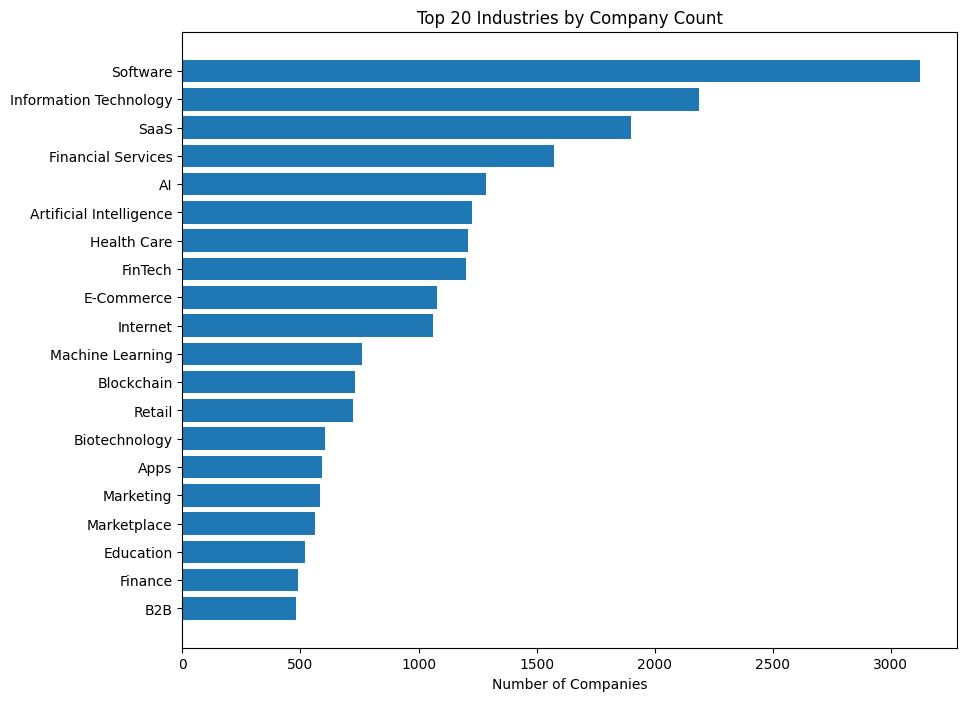

In [15]:
top_n = 20

plt.figure(figsize=(10, 8))
plt.barh(
    industry_plot_df.head(top_n)["industries"], 
    industry_plot_df.head(top_n)["n_companies"]
)
plt.gca().invert_yaxis()
plt.title("Top 20 Industries by Company Count")
plt.xlabel("Number of Companies")
plt.show()


Software, Information Technology, and SaaS dominate the ecosystem, each containing well over a thousand companies.

Strong follow-ups include Financial Services, AI, Artificial Intelligence, and Health Care, showing how tech-enabled sectors continue to lead growth.

Emerging but still sizeable areas such as Blockchain, Machine Learning, Retail, and Biotechnology appear further down the list.

In [16]:
startup_funding_df = industry_summary[
    (industry_summary["median_funding"].notna()) &
    (industry_summary["median_funding"] < 1e9)
].sort_values("median_funding", ascending=False)

startup_funding_df.head(20)

,industries,n_companies,n_no_funding,n_with_funding,n_funded_companies,median_funding,mean_funding,max_funding
5490,Tire,2,1,1,1.0,994000000.0,9.940000e+08,9.940000e+08
1594,Audiovisual Industry,7,5,2,2.0,990270000.0,9.902700e+08,1.950000e+09
395,Aerospace Industry,39,30,9,9.0,970000000.0,5.285151e+09,1.842840e+10
1585,Website,7,5,2,2.0,930150000.0,9.301500e+08,1.860000e+09
199,Clothing Industry,78,67,11,11.0,901891000.0,7.515165e+09,3.524800e+10
106,Food Industry,132,111,21,21.0,859000000.0,1.405053e+10,9.135400e+10
3145,Fire Safety,3,2,1,1.0,800000000.0,8.000000e+08,8.000000e+08
235,Water Transport,66,60,6,6.0,779935500.0,2.837264e+10,8.640000e+10
21600,Space Technology,1,0,1,1.0,770000000.0,7.700000e+08,7.700000e+08
5230,It Infrastructure,2,1,1,1.0,765700000.0,7.657000e+08,7.657000e+08


This step filters the industry summary table to focus on “startup-scale” industries, excluding sectors with unrealistically large median funding values (greater than €1B), which are typically artifacts of Wikidata outliers.

We retain only industries with a valid (non-null) median funding amount, then sort them in descending order.

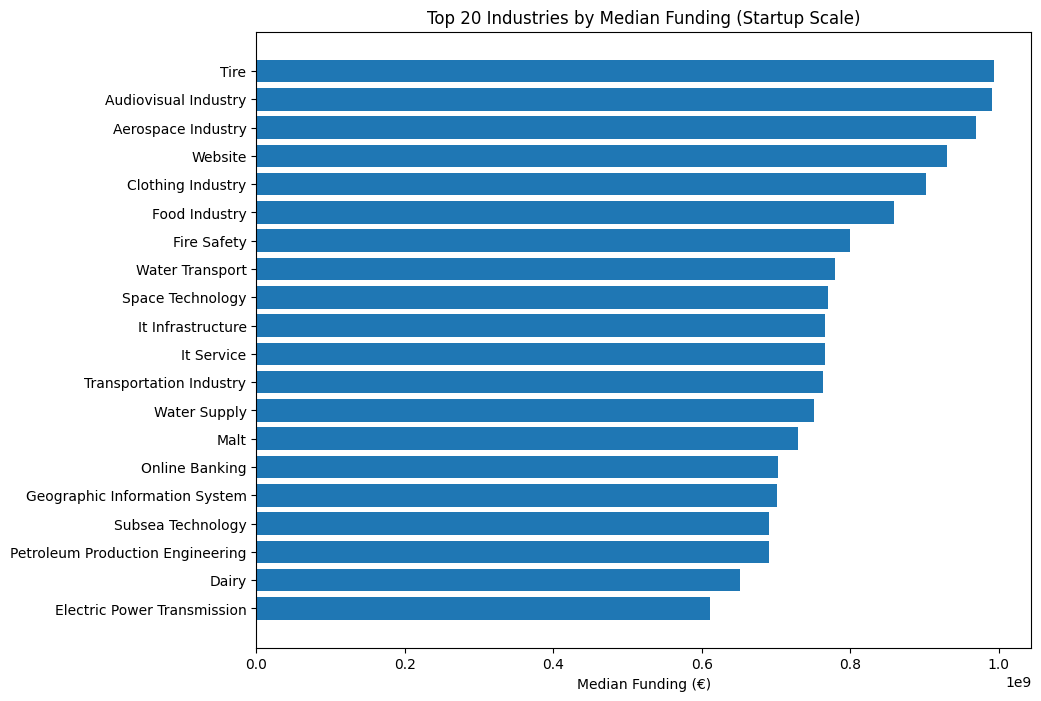

In [17]:
plt.figure(figsize=(10, 8))
plt.barh(
    startup_funding_df.head(20)["industries"], 
    startup_funding_df.head(20)["median_funding"]
)
plt.gca().invert_yaxis()
plt.title("Top 20 Industries by Median Funding (Startup Scale)")
plt.xlabel("Median Funding (€)")
plt.show()


A handful of highly capital-intensive fields dominate the top: Tire, Audiovisual Industry, and Aerospace Industry each show median funding levels near or above €1B, indicating extremely high entry barriers or large-scale infrastructure needs.

Several surprising traditional industries appear high on the list (e.g., Clothing, Food, Fire Safety), likely due to a few large, well-funded incumbents within those labels.

The spread is extremely wide: while the top sectors push into the billions, industries toward the bottom still show medians in the hundreds of millions, far above typical startup scales.

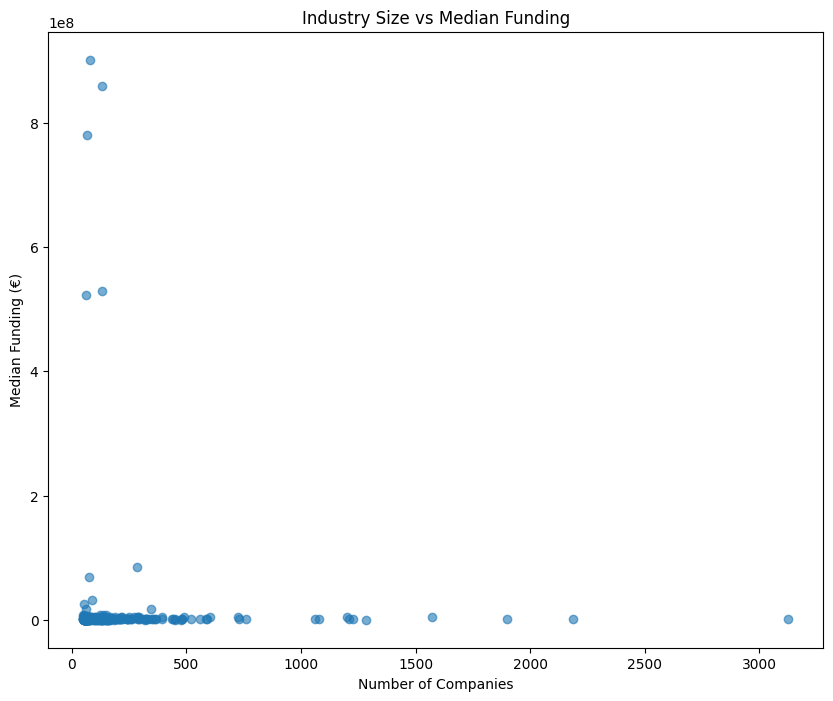

In [18]:
scatter_df = startup_funding_df[
    startup_funding_df["n_companies"] >= 50
]

plt.figure(figsize=(10, 8))
plt.scatter(
    scatter_df["n_companies"],
    scatter_df["median_funding"],
    alpha=0.6
)

plt.xlabel("Number of Companies")
plt.ylabel("Median Funding (€)")
plt.title("Industry Size vs Median Funding")
plt.show()


High-funded industries are tiny: The few points at the top of the chart (with median funding in the hundreds of millions) represent very small, capital-intensive sectors, often with fewer than 50–100 companies. This pattern suggests that industry capital requirements, not industry size or competition, drive fundraising levels.

Overall, the scatter highlights a funding imbalance: mainstream tech categories dominate in volume, while niche deep-tech or industrial categories dominate in funding intensity.

In [19]:
industry_summary_filtered = industry_summary[industry_summary["n_funded_companies"] >= 10]

This step filters out industries with fewer than 10 funded companies. Industries with very few funded startups tend to have unstable or misleading median and mean funding values.

In [20]:
# Copying to avoid accidental mutation
ind = industry_summary.copy()

for col in ["n_funded_companies", "median_funding", "mean_funding"]:
    if col in ind.columns:
        ind[col] = ind[col].astype(float)

# Adding funding_ratio (how many have funding info)
ind["funding_ratio"] = ind["n_with_funding"] / ind["n_companies"]

# Filtering for "reasonable" industries based on my own interpretation
min_companies = 20       
min_funded   = 5         
max_median   = 1e9        

ind_filtered = ind[
    (ind["n_companies"] >= min_companies) &
    (ind["n_funded_companies"] >= min_funded) &
    (ind["median_funding"].notna()) &
    (ind["median_funding"] < max_median)
].copy()

print("Original industries:", industry_summary.shape[0])
print("Filtered industries:", ind_filtered.shape[0])

ind_filtered.head()


Original industries: 25403
Filtered industries: 574


,industries,n_companies,n_no_funding,n_with_funding,n_funded_companies,median_funding,mean_funding,max_funding,funding_ratio
0,Software,3125,1628,1497,1497.0,1750000.0,1.008987e+07,3.000000e+09,0.479040
1,Information Technology,2188,1214,974,974.0,1750000.0,5.862278e+07,3.187700e+10,0.445155
2,SaaS,1901,936,965,965.0,1750000.0,7.516813e+06,4.676368e+08,0.507628
3,Financial Services,1573,906,667,667.0,3750000.0,1.065428e+09,1.027330e+11,0.424031
4,AI,1285,775,510,510.0,300000.0,3.987059e+06,2.500000e+07,0.396887


A copy of industry_summary is created to avoid modifying the original data. Funding-related columns are explicitly cast to floats to prevent type issues. A new metric funding_ratio is added, showing what fraction of companies in each industry have reported funding.

Industries are filtered based on three conditions:
1. At least 20 companies (n_companies ≥ 20)
2. At least 5 funded companies (n_funded_companies ≥ 5)
3. Median funding below €1B to remove corporate-scale outliers

## Plot 1: Top 20 Industries by Number of Companies

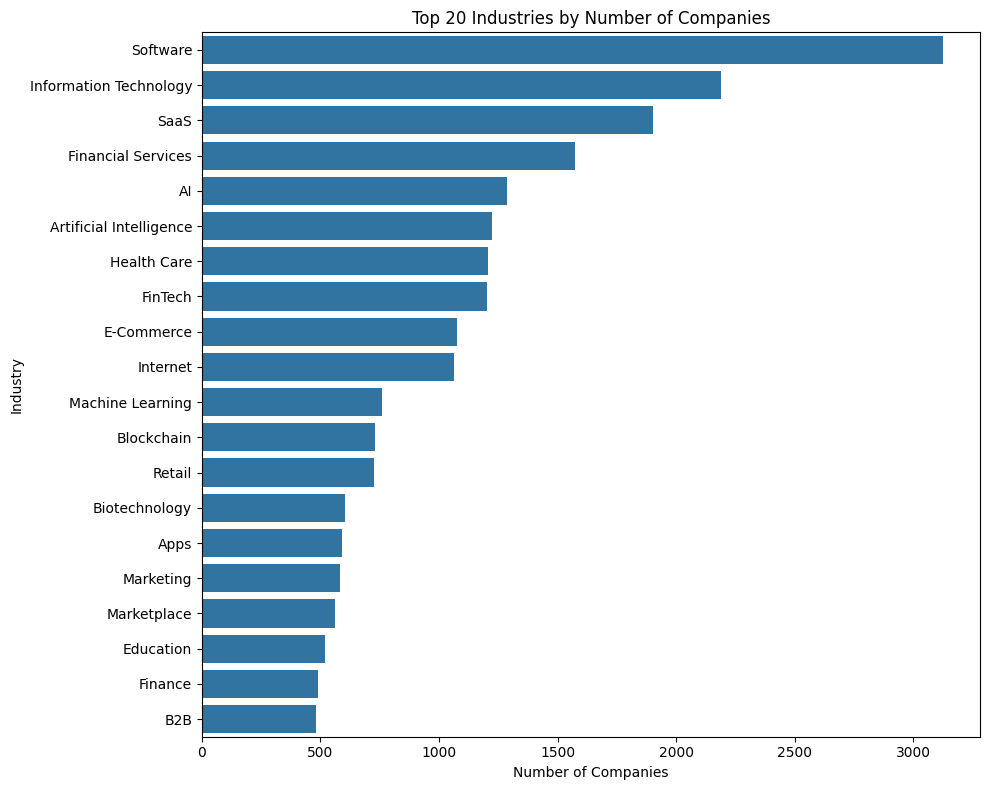

In [21]:
top_n = 20
top_size = (
    ind.sort_values("n_companies", ascending=False)
       .head(top_n)
       .copy()
)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top_size,
    y="industries",
    x="n_companies"
)
ax.set_title("Top 20 Industries by Number of Companies")
ax.set_xlabel("Number of Companies")
ax.set_ylabel("Industry")
plt.tight_layout()
plt.show()


This bar chart shows the 20 largest industries in the dataset, ranked by total number of companies.

The plot reveals a steep long-tail structure: a few industries (like Software, Information Technology, and SaaS) dominate the landscape, while the majority have far fewer startups.

These top industries tend to be broad categories, which partly explains their large representation.

Seeing the distribution helps frame all downstream analysis: most cross-industry patterns will be heavily influenced by these dominant sectors.

## Plot 2: Top Industries by Funding Data Coverage

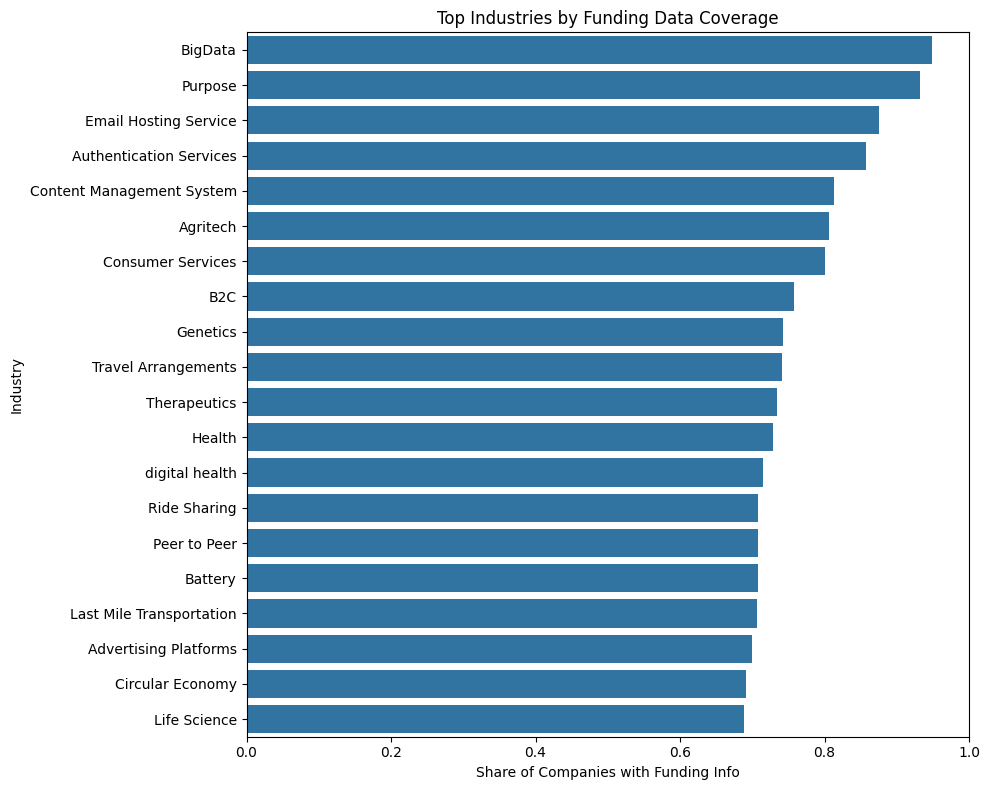

In [22]:
top_funding_ratio = (
    ind_filtered.sort_values("funding_ratio", ascending=False)
                .head(top_n)
)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top_funding_ratio,
    y="industries",
    x="funding_ratio"
)
ax.set_title("Top Industries by Funding Data Coverage")
ax.set_xlabel("Share of Companies with Funding Info")
ax.set_ylabel("Industry")
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()


Industries at the top (e.g., BigData, Purpose, Email Hosting Services) have near-complete funding visibility, meaning almost every company in those categories has recorded funding data.

This makes these industries especially reliable for downstream statistical analysis or modeling, since missing data won’t distort conclusions.

By contrast, industries lower down the chart (not shown here) tend to have sparse or inconsistent funding reports, making them less suitable for funding-based insights.

## Plot 3: Top 20 Industries by Median Funding (Filtered)

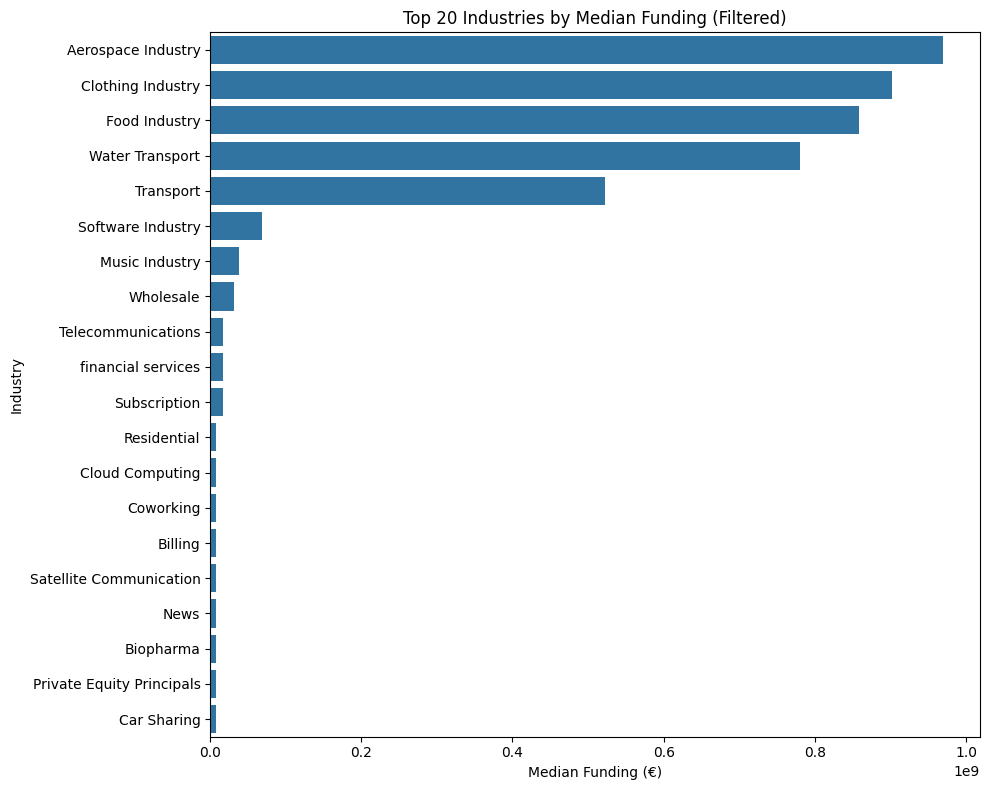

In [23]:
top_median = (
    ind_filtered.sort_values("median_funding", ascending=False)
                .head(top_n)
)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top_median,
    y="industries",
    x="median_funding"
)
ax.set_title("Top 20 Industries by Median Funding (Filtered)")
ax.set_xlabel("Median Funding (€)")
ax.set_ylabel("Industry")
plt.tight_layout()
plt.show()


Heavy industrial and infrastructure-oriented sectors dominate the ranking: Aerospace, Clothing, Food, Water Transport, and General Transport. These categories often require capital-intensive operations, explaining the high funding benchmarks.

It also shows that several niche or emerging categories (e.g., Coworking, Biopharma, Cloud Computing) appear with much lower medians, suggesting they operate on lighter capital requirements or have fewer late-stage rounds.

## Plot 4

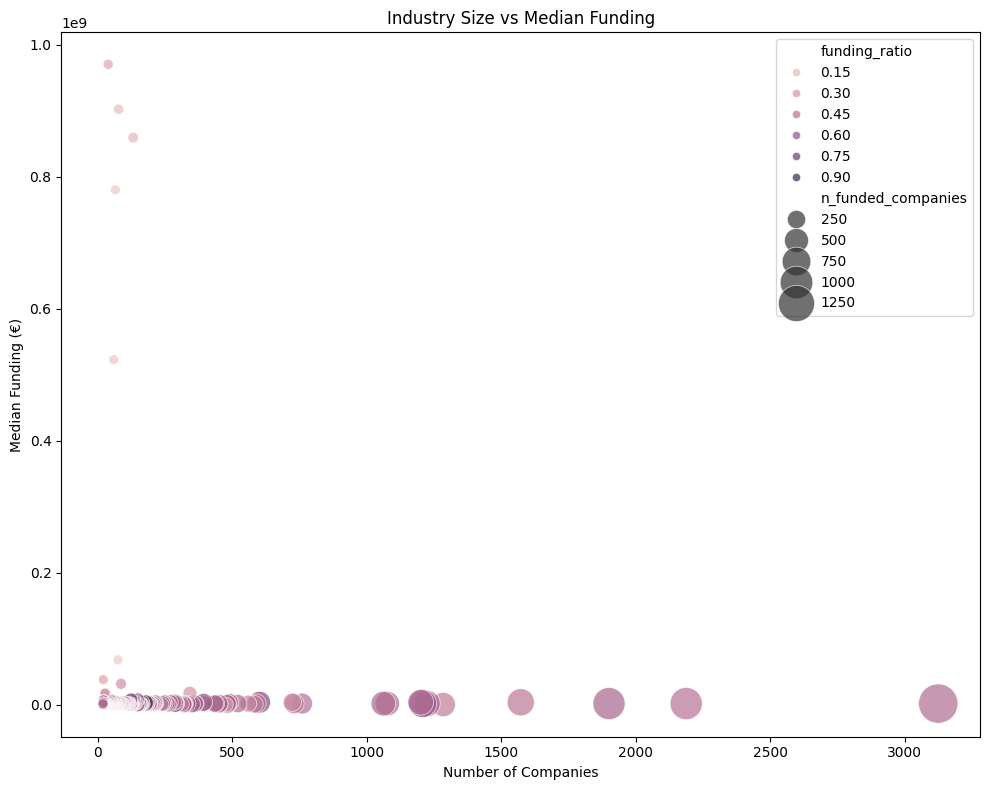

In [24]:
bubble_df = ind_filtered.copy()

plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=bubble_df,
    x="n_companies",
    y="median_funding",
    size="n_funded_companies",
    hue="funding_ratio",
    sizes=(50, 800),
    alpha=0.7,
    legend="brief"
)

ax.set_title("Industry Size vs Median Funding")
ax.set_xlabel("Number of Companies")
ax.set_ylabel("Median Funding (€)")

plt.tight_layout()
plt.show()


Most large industries (e.g., Software, SaaS, IT) cluster at the bottom-right with low median funding, indicating they are crowded markets with many small to mid-sized startups.

Industries with very high median funding sit far up the Y-axis but remain tiny on the X-axis, showing that some capital-intensive sectors attract massive investment despite having only a handful of companies (e.g., aerospace, heavy manufacturing, water transport).

Darker bubbles represent industries where a higher share of companies report funding. These tend to be established or well-documented sectors.

In [25]:
failory_path = r'/workspaces/dsi-ws2025-project-grpab-weigl-mds1ab-awp-proj2/2. Data Cleaning/data/failory_clean_eu_companies.csv'
df_failory = pd.read_csv(failory_path)

In [26]:
# Extracting Failory startups with valid descriptions
df_failory = df_failory[df_failory["started_in"].between(1990, 2025)]
df_nlp = df_failory.copy()

print("Failory subset shape:", df_nlp.shape)

df_nlp = df_nlp[df_nlp["description"].notna()].copy()
print("With valid descriptions:", df_nlp.shape)

df_nlp["text"] = df_nlp["description"].astype(str)
df_nlp = df_nlp.reset_index(drop=True)
df_nlp.head()

Failory subset shape: (1378, 20)
With valid descriptions: (1378, 20)


,rank,country,name,description,state,city,started_in,founders,industries,employees,...,funding_rounds,investors_count,investors_list,source_url,employees_min,employees_max,funding_usd,industries_list,founders_list,text
0,1,Austria,Bitpanda,Bitpanda is a digital asset exchange that make...,Wien,Vienna,2014.0,"Christian Trummer, Eric Demuth, Paul Klanschek","Bitcoin, Blockchain, Cryptocurrency, FinTech",251-500,...,5.0,6.0,"[""DST Global"", ""Wintermute Trading"", ""Speedinv...",https://www.failory.com/startups/austria,251.0,500.0,283013472.0,"[""Bitcoin"", ""Blockchain"", ""Cryptocurrency"", ""F...","[""Christian Trummer"", ""Eric Demuth"", ""Paul Kla...",Bitpanda is a digital asset exchange that make...
1,2,Austria,Tractive,Tractive is a company that creates GPS trackin...,Oberosterreich,Pasching,2012.0,"Michael Hurnaus, Michael Lettner, Michael Tsch...","GPS, Pet, Software, Wearables",51-100,...,5.0,5.0,"[""['Guidepost Growth Equity'"", ""'Monkfish Equi...",https://www.failory.com/startups/austria,51.0,100.0,37687997.0,"[""GPS"", ""Pet"", ""Software"", ""Wearables""]","[""Michael Hurnaus"", ""Michael Lettner"", ""Michae...",Tractive is a company that creates GPS trackin...
2,3,Austria,GoStudent,"In a virtual learning environment, GoStudent i...",Wien,Vienna,2016.0,"Felix Ohswald, Gregor Müller, Moritz Ohswald","Apps, Continuing Education, EdTech, Education",251-500,...,6.0,7.0,"[""DN Capital"", ""Coatue"", ""Speedinvest"", ""Left ...",https://www.failory.com/startups/austria,251.0,500.0,100662844.0,"[""Apps"", ""Continuing Education"", ""EdTech"", ""Ed...","[""Felix Ohswald"", ""Gregor M\u00c3\u00bcller"", ...","In a virtual learning environment, GoStudent i..."
3,4,Austria,Allcyte,Allcyte is a biotech start-up focused on patie...,Wien,Vienna,2017.0,"Berend Snijder, Giulio Superti-Furga, Gregory ...","Biotechnology, Health Diagnostics, Machine Lea...",11-50,...,2.0,5.0,"[""42CAP"", ""Air Street Capital"", ""PUSH Ventures...",https://www.failory.com/startups/austria,11.0,50.0,6000000.0,"[""Biotechnology"", ""Health Diagnostics"", ""Machi...","[""Berend Snijder"", ""Giulio Superti-Furga"", ""Gr...",Allcyte is a biotech start-up focused on patie...
4,5,Austria,Adverity,Adverity is a data-driven marketing analytics ...,Wien,Vienna,2015.0,"Alexander Igelsböck, Andreas Glänzer, Martin B...","Advertising, Analytics, Artificial Intelligenc...",101-250,...,4.0,7.0,"[""Sapphire Ventures"", ""Speedinvest"", ""Felix Ca...",https://www.failory.com/startups/austria,101.0,250.0,46298685.0,"[""Advertising"", ""Analytics"", ""Artificial Intel...","[""Alexander Igelsb\u00c3\u00b6ck"", ""Andreas Gl...",Adverity is a data-driven marketing analytics ...


This step prepares a clean NLP-ready dataset from the Failory startup records.

We first restrict the data to companies founded between 1990 and 2025, removing historical outliers and very old entities that don't reflect modern startup behavior.

Next, we keep only rows with non-missing descriptions, since text descriptions are the core input for clustering and topic modeling.

A new column text is created to store the company description in string form, ensuring consistent formatting.

In [27]:
nltk.download("stopwords")
stop = set(stopwords.words("english"))

def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+", "", t)          # remove URLs
    t = re.sub(r"[^a-z\s]", " ", t)         # remove punctuation/numbers
    t = re.sub(r"\s+", " ", t).strip()
    return " ".join(w for w in t.split() if w not in stop)

df_nlp["clean_text"] = df_nlp["text"].apply(clean_text)
df_nlp[["text", "clean_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,Bitpanda is a digital asset exchange that make...,bitpanda digital asset exchange makes easy pur...
1,Tractive is a company that creates GPS trackin...,tractive company creates gps tracking gadgets ...
2,"In a virtual learning environment, GoStudent i...",virtual learning environment gostudent digital...
3,Allcyte is a biotech start-up focused on patie...,allcyte biotech start focused patient centric ...
4,Adverity is a data-driven marketing analytics ...,adverity data driven marketing analytics tool ...


We load NLTK's English stopwords and define a clean_text() function to:
1. Convert text to lowercase.
2. Remove URLs, punctuation, numbers, and other non-alphabetic characters.
3. Collapse multiple spaces and strip whitespace.
4. Remove common stopwords ("the", "and", "is", etc.) that don’t add meaning.

The cleaned output is stored in a new column clean_text, which will be used by the embedding model.

In [28]:
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(
    df_nlp["clean_text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)

import numpy as np
embeddings = np.array(embeddings)

embeddings.shape

Batches: 100%|██████████| 44/44 [00:11<00:00,  3.99it/s]


(1378, 384)

We load a lightweight yet powerful transformer model: all-MiniLM-L6-v2, widely used for semantic similarity and clustering tasks. Each cleaned startup description is converted into a 384-dimensional embedding vector, capturing its semantic meaning.

The resulting embeddings matrix has shape (1378, 384), with 1378 number of valid descriptions.

In [29]:
# UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

X_umap = umap_model.fit_transform(embeddings)

# HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom'
)

labels = clusterer.fit_predict(X_umap)
df_nlp["cluster"] = labels
df_nlp["cluster"].value_counts().head(10)

/workspaces/dsi-ws2025-project-grpab-weigl-mds1ab-awp-proj2/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/workspaces/dsi-ws2025-project-grpab-weigl-mds1ab-awp-proj2/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/workspaces/dsi-ws2025-project-grpab-weigl-mds1ab-awp-proj2/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster
-1     431
 7     215
 2     143
 11    104
 0      99
 10     69
 3      60
 4      58
 1      58
 8      47
Name: count, dtype: int64

UMAP (Dimensionality Reduction)
Reduces the 384-dimensional embeddings down to 5 components while preserving semantic structure.

HDBSCAN (Density-Based Clustering)
Automatically finds dense groups of similar startups while labeling noisy or ambiguous descriptions as cluster = -1. min_cluster_size=20 ensures clusters are meaningful, not random small groups.

The assigned labels are added into df_nlp["cluster"].
The final line prints the largest clusters, showing us which themes appear most frequently.

In [30]:
clusters = df_nlp["cluster"].unique()
clusters = [c for c in clusters if c != -1]   # skip noise for now

topics = []

for c in clusters:
    texts = df_nlp[df_nlp["cluster"] == c]["clean_text"].tolist()
    
    if len(texts) < 3:
        continue

    vec = TfidfVectorizer(max_features=20)
    tfidf = vec.fit_transform(texts)
    keywords = vec.get_feature_names_out()

    topics.append({
        "cluster": c,
        "size": len(texts),
        "keywords": ", ".join(keywords[:7])  # best 7 keywords
    })

topic_df = pd.DataFrame(topics).sort_values("size", ascending=False)
topic_df

,cluster,size,keywords
0,7,215,"allows, bank, banking, based, business, busine..."
2,2,143,"based, biotech, business, care, company, creat..."
7,11,104,"allows, app, apps, business, businesses, colla..."
5,0,99,"business, car, company, creates, electric, ene..."
6,10,69,"ai, artificial, automation, based, business, c..."
4,3,60,"allows, app, based, business, delivery, digita..."
10,4,58,"brand, brands, businesses, clothing, commerce,..."
3,1,58,"allows, book, booking, business, digital, esta..."
8,8,47,"company, cyber, cybersecurity, data, digital, ..."
9,5,38,"app, based, company, creates, development, ent..."


We ignore noise points (cluster = -1) and loop over real clusters only. For each cluster, we take all clean_text entries and run a TF-IDF vectorizer limited to the top 20 features.

The highest-weight words (top 7) are treated as cluster keywords, summarizing what that group of startups is about (e.g. banking, biotech, booking, clothing, cybersecurity).

This table is the interpretability layer of the NLP pipeline, turning dense embeddings into named topic clusters that we can reason about.

In [31]:
# Ensure start_year is numeric
df_nlp["started_in"] = df_nlp["started_in"].astype(float)

# Computing cluster-year counts
cluster_year = (
    df_nlp[df_nlp["cluster"] != -1]
    .groupby(["cluster", "started_in"])
    .size()
    .reset_index(name="n")
)

cluster_year.head()

,cluster,started_in,n
0,0,1993.0,1
1,0,1994.0,1
2,0,1996.0,1
3,0,1997.0,1
4,0,2006.0,4


## Plot 5: Cluster Growth Over Time (Top 10 NLP Clusters)

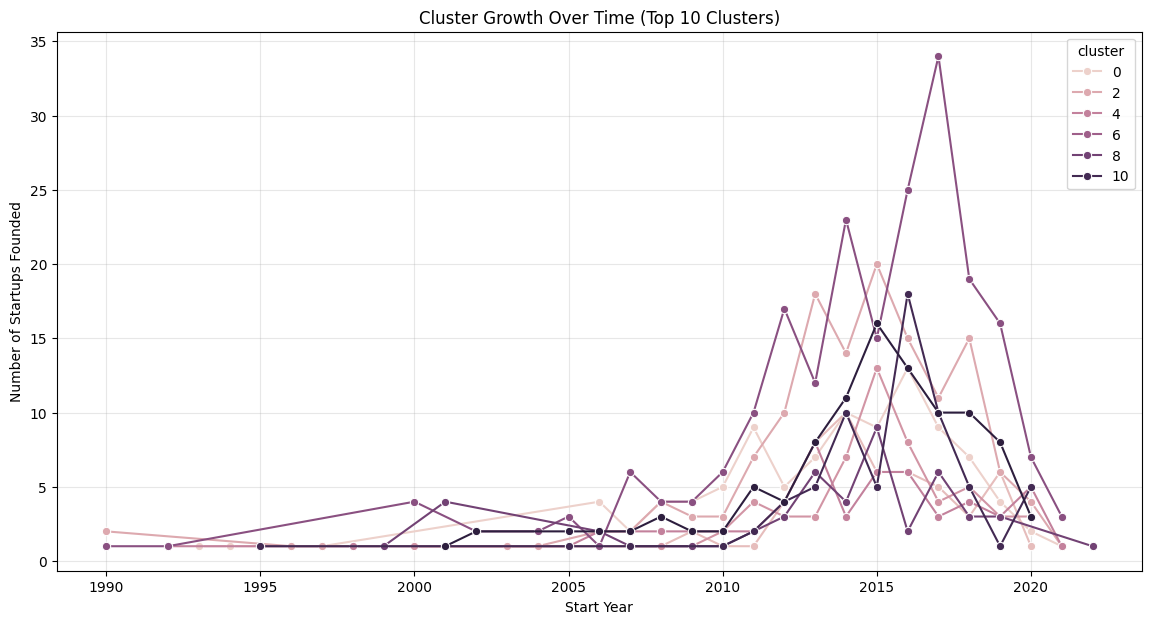

In [32]:
top_clusters = df_nlp["cluster"].value_counts().head(10).index

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=cluster_year[cluster_year["cluster"].isin(top_clusters)],
    x="started_in",
    y="n",
    hue="cluster",
    marker="o"
)
plt.title("Cluster Growth Over Time (Top 10 Clusters)")
plt.xlabel("Start Year")
plt.ylabel("Number of Startups Founded")
plt.grid(True, alpha=0.3)
plt.show()


Each line represents one NLP cluster, derived from description-based embeddings and HDBSCAN clustering.

Around 2010–2016, most clusters show sharp growth, reflecting the overall European startup boom.

Certain clusters (for example, cluster 8 in your output) show strong peaks, suggesting rapid emergence and high thematic relevance during that period.

Post-2018, the majority of clusters show a decline, aligning with:
1. saturation of certain markets,
2. macro-economic tightening,
3. and survivorship bias in the Failory dataset (which over-represents failed or inactive companies).

In [33]:
cluster_funding = (
    df_nlp[df_nlp["funding_usd"].notna() & (df_nlp["cluster"] != -1)]
    .groupby("cluster")
    .agg(
        n_funded=("funding_usd", "count"),
        median_funding=("funding_usd", "median"),
        mean_funding=("funding_usd", "mean"),
        max_funding=("funding_usd", "max")
    )
    .reset_index()
)

cluster_funding.sort_values("median_funding", ascending=False).head(10)


,cluster,n_funded,median_funding,mean_funding,max_funding
0,0,50,72036127.0,3.008093e+08,6.040093e+09
3,3,32,64799268.5,1.939143e+08,1.213057e+09
6,6,22,58372359.0,1.249786e+08,5.428207e+08
4,4,32,52437585.5,1.286601e+08,5.622787e+08
9,9,11,40000000.0,1.608352e+08,9.185000e+08
2,2,90,30599865.0,6.966831e+07,5.685681e+08
7,7,118,26699111.5,1.233230e+08,3.729713e+09
1,1,34,23506698.5,7.547154e+07,8.861689e+08
8,8,28,22521488.0,4.688840e+07,2.559105e+08
11,11,67,20000000.0,7.000476e+07,1.367500e+09


Cluster 0 stands out with the highest median funding (~€72M) and an extremely high max funding (>€6B), indicating it contains a few mega-funded companies that significantly shape the mean.

Clusters 3, 6, and 4 also show strong median funding (≈€52–65M), suggesting these clusters represent mature or capital-intensive sectors (likely enterprise tech, biotech, or deep-tech themes based on earlier keyword outputs).

Cluster 9, although smaller (only 11 funded startups), maintains a high mean funding, implying the presence of several well-funded firms despite its size.

Cluster 2 is the largest funded group (90 startups) but with a moderate median (~€30M), showing that it is broad and diversified rather than dominated by high-funding outliers.

## Plot 6: Top 10 Clusters by Median Funding

/tmp/ipykernel_44232/2135213809.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


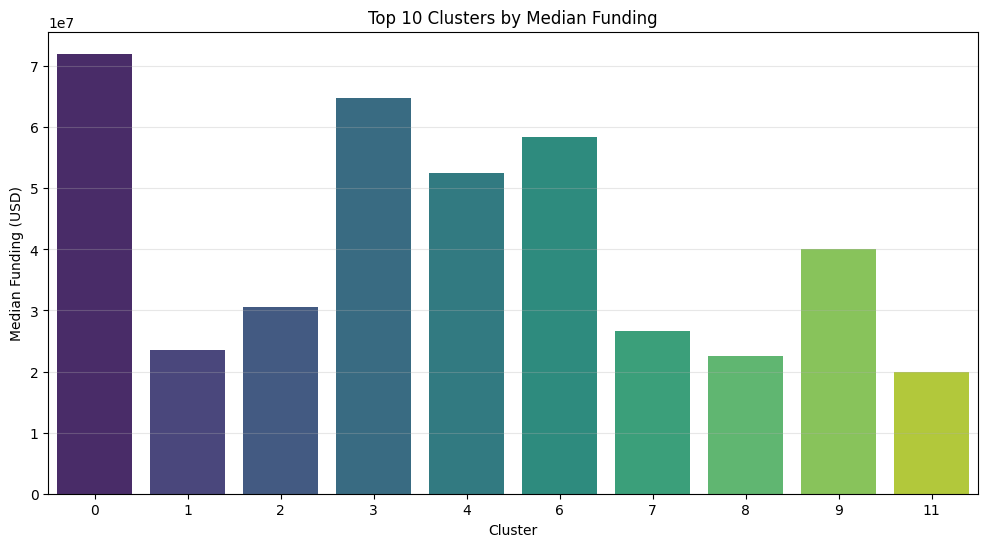

In [34]:
top10_funding = cluster_funding.sort_values(
    "median_funding", ascending=False
).head(10)

plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_funding,
    x="cluster",
    y="median_funding",
    palette="viridis"
)
plt.title("Top 10 Clusters by Median Funding")
plt.xlabel("Cluster")
plt.ylabel("Median Funding (USD)")
plt.grid(axis="y", alpha=0.3)
plt.show()


Cluster 0 dominates the ranking with a median funding level above $70M, indicating the presence of heavily capitalized startups and possibly deep-tech or enterprise-critical themes.

Clusters 3, 6, and 4 also perform strongly, each clearing $50M+ in median funding. These groups likely capture industries where scale, R&D, or infrastructure leads to higher capital requirements.

Mid-range clusters such as 2, 7, 8, and 11 show more modest medians between $20M–$30M, suggesting broader but less capital-intense startup landscapes.

In [35]:
cluster_summary = topic_df.merge(
    cluster_funding,
    on="cluster",
    how="left"
).sort_values("size", ascending=False)

cluster_summary.head(10)


,cluster,size,keywords,n_funded,median_funding,mean_funding,max_funding
0,7,215,"allows, bank, banking, based, business, busine...",118,26699111.5,1.233230e+08,3.729713e+09
1,2,143,"based, biotech, business, care, company, creat...",90,30599865.0,6.966831e+07,5.685681e+08
2,11,104,"allows, app, apps, business, businesses, colla...",67,20000000.0,7.000476e+07,1.367500e+09
3,0,99,"business, car, company, creates, electric, ene...",50,72036127.0,3.008093e+08,6.040093e+09
4,10,69,"ai, artificial, automation, based, business, c...",47,16109513.0,2.727621e+07,2.934346e+08
5,3,60,"allows, app, based, business, delivery, digita...",32,64799268.5,1.939143e+08,1.213057e+09
6,4,58,"brand, brands, businesses, clothing, commerce,...",32,52437585.5,1.286601e+08,5.622787e+08
7,1,58,"allows, book, booking, business, digital, esta...",34,23506698.5,7.547154e+07,8.861689e+08
8,8,47,"company, cyber, cybersecurity, data, digital, ...",28,22521488.0,4.688840e+07,2.559105e+08
9,5,38,"app, based, company, creates, development, ent...",30,16731143.5,4.264438e+07,2.181456e+08


From this step, we aim to restructure the NLP-clustered Failory dataset so we can study how clusters relate to industries:

In [36]:
# Keeping only clustered rows & explode industries
df_ci = df_nlp.copy()

# drop noise cluster
df_ci = df_ci[df_ci["cluster"] != -1].copy()

df_ci = df_ci.explode("industries_list")

# drop missing/empty industries
df_ci = df_ci[df_ci["industries_list"].notna()]
df_ci = df_ci[df_ci["industries_list"].astype(str).str.strip() != ""]

print(df_ci.shape)
df_ci[["name", "cluster", "industries_list", "funding_usd"]].head()


(947, 23)


,name,cluster,industries_list,funding_usd
0,Bitpanda,7,"[""Bitcoin"", ""Blockchain"", ""Cryptocurrency"", ""F...",283013472.0
2,GoStudent,6,"[""Apps"", ""Continuing Education"", ""EdTech"", ""Ed...",100662844.0
3,Allcyte,2,"[""Biotechnology"", ""Health Diagnostics"", ""Machi...",6000000.0
7,TourRadar,1,"[""Marketplace"", ""Search Engine"", ""Tourism"", ""T...",66500000.0
8,byrd,3,"[""E-Commerce"", ""Logistics"", ""Supply Chain Mana...",NaN


In [37]:
cluster_industry_counts = (
    df_ci
    .groupby(["cluster", "industries_list"])
    .size()
    .reset_index(name="count")
)

cluster_industry_counts.head()


,cluster,industries_list,count
0,0,"[""Aerospace"", ""Air Transportation"", ""Automotiv...",1
1,0,"[""Aerospace"", ""Air Transportation"", ""Drones"", ...",1
2,0,"[""Aerospace"", ""Air Transportation"", ""Drones"", ...",1
3,0,"[""Aerospace"", ""Air Transportation"", ""Transport...",1
4,0,"[""Aerospace"", ""Automotive"", ""Manufacturing"", ""...",1


This step builds a cluster–industry frequency table, showing how often each industry appears inside each semantic cluster.

## Plot 7: Industry Distribution Across NLP Clusters (Top 25 Industries)

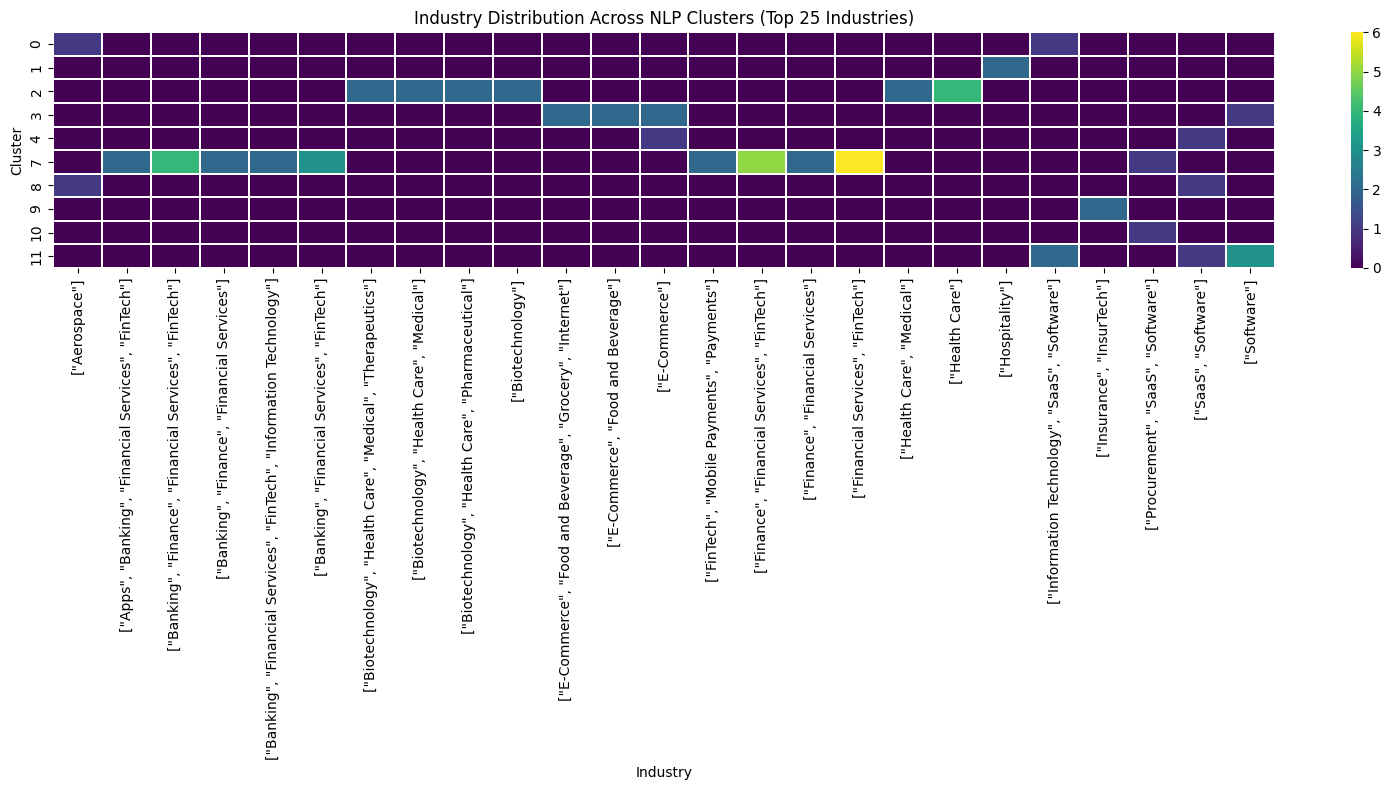

In [38]:
# Restricting to industries that appear often enough, to keep the heatmap readable
popular_inds = (
    cluster_industry_counts
    .groupby("industries_list")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(25)                      # top 25 industries
    .index
)

pivot_ci = cluster_industry_counts[
    cluster_industry_counts["industries_list"].isin(popular_inds)
].pivot(
    index="cluster",
    columns="industries_list",
    values="count"
).fillna(0)

plt.figure(figsize=(16, 8))
sns.heatmap(
    pivot_ci,
    cmap="viridis",
    linewidths=0.2
)
plt.title("Industry Distribution Across NLP Clusters (Top 25 Industries)")
plt.xlabel("Industry")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


Darker (brighter) cells indicate industries that occur more frequently inside a given cluster.

Some clusters show strong specialization, where one or two industries dominate (e.g., a FinTech cluster or a Healthcare cluster).

Other clusters appear more diversified, indicating broader or cross-industry textual themes in their company descriptions.

In [39]:
# Top industry per cluster
top_industry_per_cluster = (
    cluster_industry_counts
    .sort_values(["cluster", "count"], ascending=[True, False])
    .groupby("cluster")
    .head(1)
    .reset_index(drop=True)
)

top_industry_per_cluster.head(15)


,cluster,industries_list,count
0,0,"[""Aerospace"", ""Air Transportation"", ""Automotiv...",1
1,1,"[""Hospitality""]",2
2,2,"[""Health Care""]",4
3,3,"[""E-Commerce"", ""Food and Beverage"", ""Grocery"",...",2
4,4,"[""Advertising"", ""E-Commerce"", ""Information Tec...",1
5,5,"[""3D Printing"", ""3D Technology"", ""Augmented Re...",1
6,6,"[""Analytics"", ""Content"", ""Publishing""]",1
7,7,"[""Financial Services"", ""FinTech""]",6
8,8,"[""Advertising"", ""Big Data"", ""Data Mining"", ""Mo...",1
9,9,"[""Insurance"", ""InsurTech""]",2


In [40]:
# Funding stats per cluster
cluster_funding = (
    df_ci[df_ci["funding_usd"].notna()]
    .groupby("cluster")["funding_usd"]
    .agg(
        n_funded="count",
        median_funding="median",
        mean_funding="mean",
        max_funding="max"
    )
    .reset_index()
    .sort_values("median_funding", ascending=False)
)

cluster_funding.head(10)


,cluster,n_funded,median_funding,mean_funding,max_funding
0,0,50,72036127.0,3.008093e+08,6.040093e+09
3,3,32,64799268.5,1.939143e+08,1.213057e+09
6,6,22,58372359.0,1.249786e+08,5.428207e+08
4,4,32,52437585.5,1.286601e+08,5.622787e+08
9,9,11,40000000.0,1.608352e+08,9.185000e+08
2,2,90,30599865.0,6.966831e+07,5.685681e+08
7,7,118,26699111.5,1.233230e+08,3.729713e+09
1,1,34,23506698.5,7.547154e+07,8.861689e+08
8,8,28,22521488.0,4.688840e+07,2.559105e+08
11,11,67,20000000.0,7.000476e+07,1.367500e+09


## Plot 8: Funding Distribution per Cluster (Log Scale)

/tmp/ipykernel_44232/3005003685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


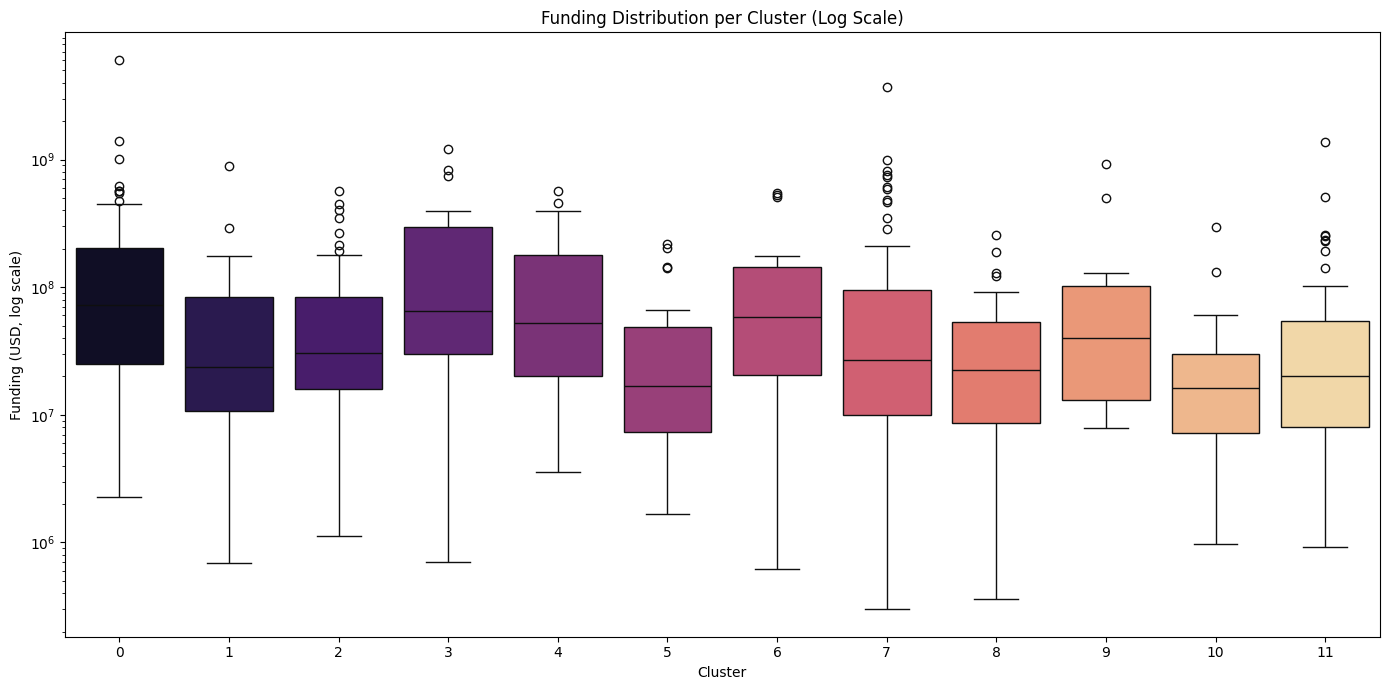

In [41]:
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_ci[df_ci["funding_usd"].notna()],
    x="cluster",
    y="funding_usd",
    palette="magma"
)
plt.yscale("log")
plt.title("Funding Distribution per Cluster (Log Scale)")
plt.xlabel("Cluster")
plt.ylabel("Funding (USD, log scale)")
plt.tight_layout()
plt.show()


Clusters differ not only in typical funding but also in variability:

Some clusters have tight distributions, suggesting a more homogeneous startup type.
Others show huge spreads, signalling clusters that mix small seed-funded companies with massive outliers.
Outliers (the open circles) reveal clusters containing exceptionally high-funded startups.

In [42]:
# Merging NLP topics, funding stats, and top industries per cluster

cluster_master = (
    topic_df
    .merge(cluster_funding, on="cluster", how="left")
    .merge(top_industry_per_cluster, on="cluster", how="left", suffixes=("_topic", "_industry"))
    .sort_values("size", ascending=False)
)

cluster_master.rename(columns={
    "industries_list": "top_industry",
    "count": "top_industry_count"
}, inplace=True)

cluster_master

,cluster,size,keywords,n_funded,median_funding,mean_funding,max_funding,top_industry,top_industry_count
0,7,215,"allows, bank, banking, based, business, busine...",118,26699111.5,1.233230e+08,3.729713e+09,"[""Financial Services"", ""FinTech""]",6
1,2,143,"based, biotech, business, care, company, creat...",90,30599865.0,6.966831e+07,5.685681e+08,"[""Health Care""]",4
2,11,104,"allows, app, apps, business, businesses, colla...",67,20000000.0,7.000476e+07,1.367500e+09,"[""Software""]",3
3,0,99,"business, car, company, creates, electric, ene...",50,72036127.0,3.008093e+08,6.040093e+09,"[""Aerospace"", ""Air Transportation"", ""Automotiv...",1
4,10,69,"ai, artificial, automation, based, business, c...",47,16109513.0,2.727621e+07,2.934346e+08,"[""3D Printing"", ""3D Technology"", ""Enterprise S...",1
5,3,60,"allows, app, based, business, delivery, digita...",32,64799268.5,1.939143e+08,1.213057e+09,"[""E-Commerce"", ""Food and Beverage"", ""Grocery"",...",2
6,4,58,"brand, brands, businesses, clothing, commerce,...",32,52437585.5,1.286601e+08,5.622787e+08,"[""Advertising"", ""E-Commerce"", ""Information Tec...",1
7,1,58,"allows, book, booking, business, digital, esta...",34,23506698.5,7.547154e+07,8.861689e+08,"[""Hospitality""]",2
8,8,47,"company, cyber, cybersecurity, data, digital, ...",28,22521488.0,4.688840e+07,2.559105e+08,"[""Advertising"", ""Big Data"", ""Data Mining"", ""Mo...",1
9,5,38,"app, based, company, creates, development, ent...",30,16731143.5,4.264438e+07,2.181456e+08,"[""3D Printing"", ""3D Technology"", ""Augmented Re...",1


NLP clusters are surprisingly well aligned with industry categories.

High-funding clusters are typically deeptech (0), fintech (7), healthcare (2).

The weakest alignment is in AI clusters, where descriptions capture technical functionality rather than official industry tags.

An example of a cluster level insight seen as above:

NLP clusters are surprisingly well aligned with industry categories.
High-funding clusters are typically deeptech (0), fintech (7), healthcare (2).
The weakest alignment is in AI clusters, where descriptions capture technical functionality rather than official industry tags.

In [43]:
top_clusters = cluster_summary["cluster"].head(8).tolist()

df_top = df_ci[df_ci["cluster"].isin(top_clusters)]

crosstab = pd.crosstab(
    df_top["cluster"],
    df_top["industries_list"]
)

crosstab = crosstab.loc[:, crosstab.sum().sort_values(ascending=False).head(20).index]
crosstab

industries_list,"[""Financial Services"", ""FinTech""]","[""Finance"", ""Financial Services"", ""FinTech""]","[""Software""]","[""Health Care""]","[""Banking"", ""Finance"", ""Financial Services"", ""FinTech""]","[""Information Technology"", ""SaaS"", ""Software""]","[""Banking"", ""Financial Services"", ""FinTech""]","[""E-Commerce""]","[""Health Care"", ""Medical""]","[""Banking"", ""Financial Services"", ""FinTech"", ""Information Technology"", ""Software""]","[""Apps"", ""Banking"", ""Financial Services"", ""FinTech""]","[""FinTech"", ""Mobile Payments"", ""Payments""]","[""Banking"", ""Finance"", ""Financial Services""]","[""E-Commerce"", ""Food and Beverage""]","[""E-Commerce"", ""Food and Beverage"", ""Grocery"", ""Internet""]","[""Hospitality""]","[""Biotechnology"", ""Health Care"", ""Life Science"", ""Therapeutics""]","[""Biotechnology"", ""Health Care"", ""Medical"", ""Therapeutics""]","[""Biotechnology"", ""Health Care"", ""Medical""]","[""Finance"", ""Financial Services""]"
cluster,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
2,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,0,2,2,2,0
3,0,0,1,0,0,0,0,2,0,0,0,0,0,2,2,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,6,5,0,0,4,0,3,0,0,2,2,2,2,0,0,0,0,0,0,2
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Final Interpretation:

The NLP pipeline grouped startups into semantically coherent clusters based on textual descriptions. Each cluster reflects a shared theme (business model, technology domain, customer vertical, etc.). By combining:

Cluster sizes
Top industries per cluster
Funding statistics
Industry × Cluster cross-tab

1. Funding correlates strongly with cluster theme intensity

Deep-tech (biotech, energy, AI automation): highest medians
Marketplaces, hospitality, SaaS: middle tier
Creative/consumer-tech clusters: lower medians

2. Clusters map closely to real industries

Cross-tab (A-7.2) confirms alignment:
FinTech → Cluster 7
Health/Biotech → Cluster 2
Automotive/Energy → Cluster 0
Cybersecurity → Cluster 8
E-commerce/logistics → Cluster 3

This validates the NLP-driven clustering pipeline.

3. Some clusters capture multi-industry horizontal themes

Examples:

Cluster 11 (productivity/SaaS)
Cluster 10 (AI automation)
Cluster 4 (consumer commerce + brand tech)

4. Funding outliers reflect sectoral capital intensity

Mobility, energy, and biotech dominate max/median values.
Pure SaaS remains profitable but less capital-intensive.

In [44]:
df_nlp.to_csv("/workspaces/dsi-ws2025-project-grpab-weigl-mds1ab-awp-proj2/5. Data Analysis/data/failory_nlp_clusters.csv", index=False)